In [25]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

In [13]:
reviews = pd.read_csv(r'../data/restaurant_reviews_upd.csv')
reviews.head()

,Restaurant,Reviewer,Review,Rating,Time,Pictures,prev_reviews_count,followers_count,Month,DayOfWeek
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,2019-05-25 15:54:00,0,1,2,5,Saturday
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,2019-05-25 14:20:00,0,3,2,5,Saturday
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,2019-05-24 22:54:00,0,2,3,5,Friday
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,2019-05-24 22:11:00,0,1,1,5,Friday
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,2019-05-24 21:37:00,0,3,2,5,Friday


Pre-process text for sentiment analysis

In [14]:
import re

def clean_text(input):
    processed_text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\d+","",input.lower())
    return processed_text

reviews['Cleaned_Reviews'] = reviews['Review'].apply(clean_text)

In [15]:
# Calculate Sentiment Polarity using TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity 

reviews['Sentiment'] = reviews['Cleaned_Reviews'].apply(get_sentiment)
reviews['Sentiment_Type'] = reviews['Sentiment'].apply(lambda x: 'positive' if x>0 else ('negative' if x<0 else 'neutral'))
reviews[['Cleaned_Reviews','Sentiment','Sentiment_Type']].head()

,Cleaned_Reviews,Sentiment,Sentiment_Type
0,the ambience was good food was quite good had...,0.660000,positive
1,ambience is too good for a pleasant evening se...,0.606667,positive
2,a must try great food great ambience thnx for ...,0.550000,positive
3,soumen das and arun was a great guy only becau...,0.500000,positive
4,food is goodwe ordered kodi drumsticks and bas...,0.577500,positive


Extracting Noun from each review for further analysis

In [16]:
nlp = spacy.load("en_core_web_sm")

def extract_food_entity(review):
    doc = nlp(review)
    food_entities = [token.text for token in doc if token.pos_ == 'NOUN']
    return food_entities

# testing: 
answer = extract_food_entity("The ambience was good, food was quite good . had Saturday lunch , which was cost effective .Good place for a sate brunch. One can also chill with friends and or parents.Waiter Soumen Das was really courteous and helpful.")
print(answer)
reviews['Food_Entities'] = reviews['Cleaned_Reviews'].apply(extract_food_entity)

reviews[['Food_Entities','Cleaned_Reviews']]

['ambience', 'food', 'lunch', 'cost', '.Good', 'place', 'brunch', 'friends', 'parents']


,Food_Entities,Cleaned_Reviews
0,"[ambience, food, lunch, cost, place, sate, bru...",the ambience was good food was quite good had...
1,"[ambience, evening, service, food, experience,...",ambience is too good for a pleasant evening se...
2,"[food, ambience, thnx, service, pradeep, recom...",a must try great food great ambience thnx for ...
3,"[guy, behavior, sincerety, food, course, place]",soumen das and arun was a great guy only becau...
4,"[food, goodwe, drumsticks, basket, mutton, bir...",food is goodwe ordered kodi drumsticks and bas...
...,...,...
9950,"[servers, staff, time, items, time, infact, ch...",madhumathi mahajan well to start with nice cou...
9951,"[place, food, staff, ambience, rice, oil, fish...",this place has never disappointed us the food ...
9952,"[rating, chicken, bone, veg, food, vegetariant...",bad rating is mainly because of chicken bone f...
9953,"[food, couple, times, husbandthe, ambiance, pl...",i personally love and prefer chinese food had ...


Calculating the cumulative sentiment for each unity

In [36]:
from collections import defaultdict 

# calculating sentiment value for the extracted nouns from the reviews
food_sentiment_value = defaultdict(lambda: {'positive': 0,'negative': 0,'neutral': 0})

for index, row in reviews.iterrows():
    sentiment = row['Sentiment_Type']
    sentiment_value = row['Sentiment']

    for ele in row['Food_Entities']:
        food_sentiment_value[ele][sentiment] += sentiment_value

reviews_noun_sentiment_df = pd.DataFrame.from_dict(food_sentiment_value,orient='index')

reviews_noun_sentiment_df.head(5)

,positive,negative,neutral
ambience,571.158724,-17.306281,0.0
food,1719.914005,-250.291961,0.0
lunch,134.550627,-14.109992,0.0
cost,24.847752,-2.613763,0.0
place,1683.921676,-110.171211,0.0


C:\Users\Nitin Flavier\AppData\Local\Temp\ipykernel_36384\4020230915.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  threshold = reviews_noun_sentiment_df['positive'].sort_values(ascending=False)[20]


134.55062723876608


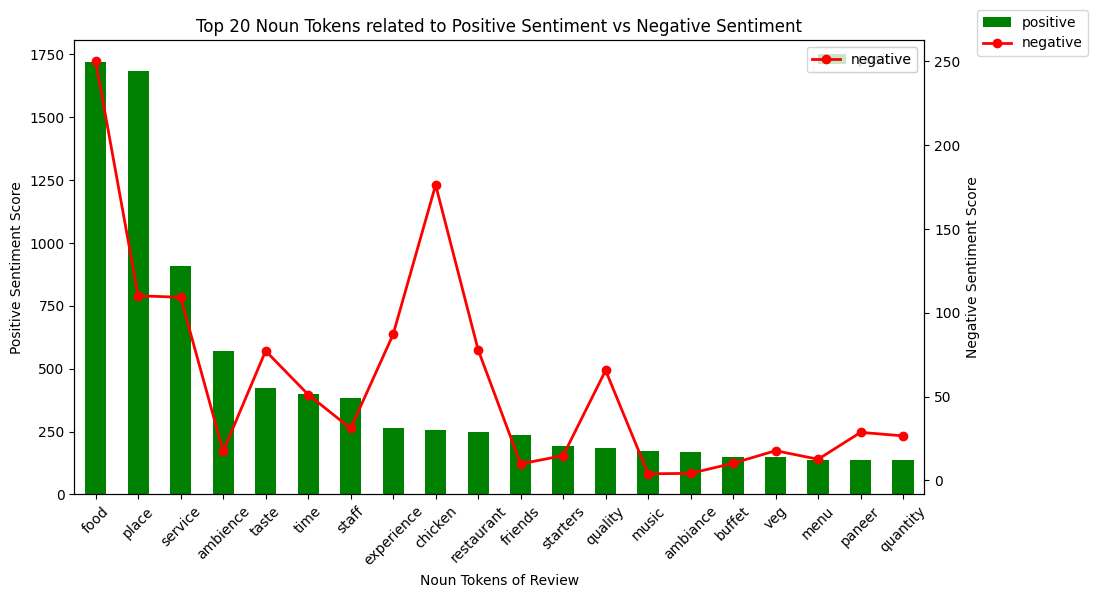

In [51]:
# finding the threhold to filter the top 20 values

threshold = reviews_noun_sentiment_df['positive'].sort_values(ascending=False)[20]
print(threshold)

top_sentiments_df = reviews_noun_sentiment_df[reviews_noun_sentiment_df['positive'] > threshold].sort_values(by='positive',ascending=False)                        
top_sentiments_df.head(20) 

# plotting
fig, ax = plt.subplots(figsize=(10,6))

top_sentiments_df[['positive']].plot(kind='bar',stacked=True,ax=ax,color='green')

ax2 = ax.twinx()
(top_sentiments_df[['negative']]*(-1)).plot(kind='line',ax=ax2,color='red',marker='o',linewidth=2)

ax.set_xlabel('Noun Tokens of Review')
ax.set_ylabel('Positive Sentiment Score')

ax2.set_ylabel('Negative Sentiment Score')

ax.set_title('Top 20 Noun Tokens related to Positive Sentiment vs Negative Sentiment')
fig.legend(loc='upper right',bbox_to_anchor=(1.1,1))
ax.set_xticklabels(top_sentiments_df.index,rotation=45)

plt.tight_layout()
plt.show()


Insights:

- Food is the Key: "Food" and "Place" has the highest mentions by a significant margin.

- Service Matters: A good service has a great impact on customer experience, which inhand improves ratings.

- Entities such as 'place', 'service' and 'ambience' have strong positive sentiment values, suggesting that these are consistently positive aspects of the restaurants included in this analysis.

- Quality over Quantity: 'Quality' has a higher positive sentiment in comparision to 'Quantity'.

- Less Impactful Words: like 'music', 'buffet', 'menu' have lower contribuition to positive sentiments.


Business Impact:

- The chart helps restaurants understand the most valued aspects by the customers, hence helping them to keep high standards in those areas.

C:\Users\Nitin Flavier\AppData\Local\Temp\ipykernel_36384\1661360250.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  threshold = reviews_noun_sentiment_df['negative'].sort_values(ascending=True)[20]


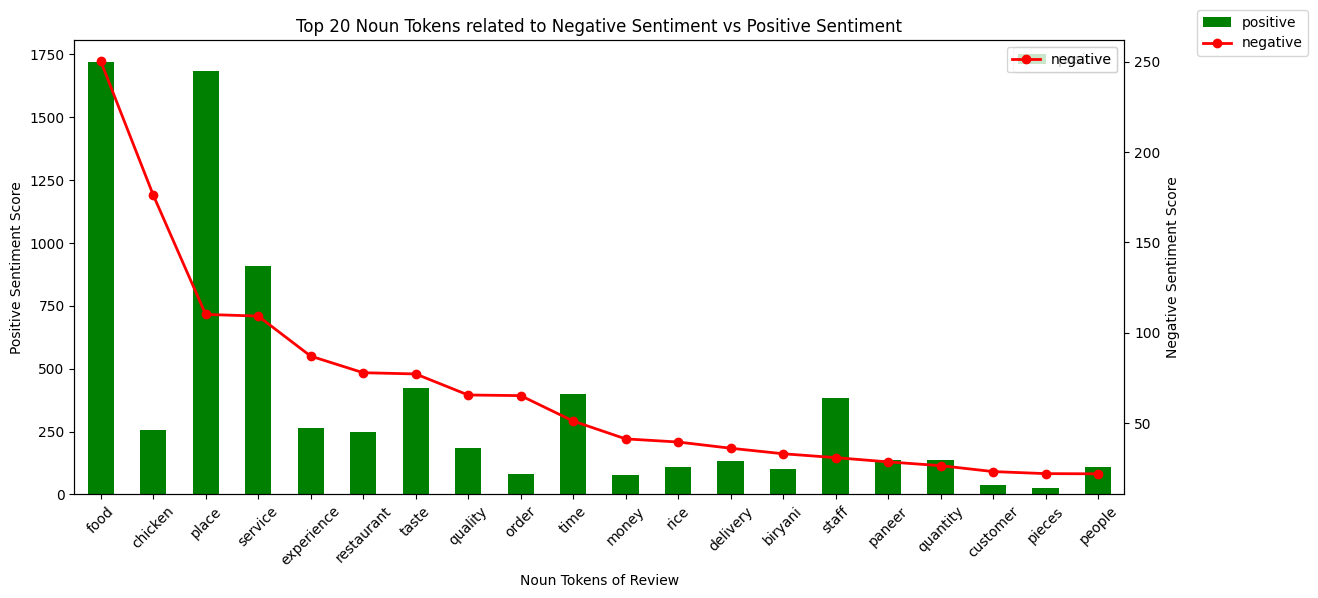

In [53]:
threshold = reviews_noun_sentiment_df['negative'].sort_values(ascending=True)[20]

neg_sentiment_df = reviews_noun_sentiment_df[reviews_noun_sentiment_df['negative'] < threshold].sort_values(by='negative',ascending=True)
neg_sentiment_df.head(20)

fig, ax = plt.subplots(figsize=(12,6))


ax2 = ax.twinx()
neg_sentiment_df[['positive']].plot(kind='bar',color='green',ax=ax)
(neg_sentiment_df[['negative']]*(-1)).plot(kind='line',ax=ax2,marker='o',linewidth=2,color='red')
ax.set_xlabel('Noun Tokens of Review')
ax.set_ylabel('Positive Sentiment Score')

ax2.set_ylabel('Negative Sentiment Score')

ax.set_title('Top 20 Noun Tokens related to Negative Sentiment vs Positive Sentiment')
fig.legend(loc='upper right',bbox_to_anchor=(1.1,1))
ax.set_xticklabels(neg_sentiment_df.index,rotation=45)

plt.tight_layout()
plt.show()


Insights:

- 'Chicken' had equally positive and negative sentiment, one of the most common dish eaten by non-vegeterians is 'Chicken' so chicken dishes are crucial to get right, as they can significantly impact customer sentiment.

- Consistency in Service: Service has a high positive sentiment, but also a notable negative sentiment. Consistent service quality could be a determining factor in overall customer satisfaction.

- Experience & Taste: Even though positive reviews are notable but bad experience and bad taste can have a huge impact on customer review.

- Operational Aspects: The negative sentiments for 'order', 'delivery', and 'time' are lower than for 'food', 'chicken', and 'place', but are still significant. This could indicate that operational efficiency in order processing and delivery is an area for improvement.

- Staff Interaction: Staff have higher positive sentiment and comparatively lower negative sentiment. This suggests that good staff interactions can greatly enhance the customer experience, but poor interactions have less impact on negative sentiment compared to food quality or place.



Overall, focusing on areas with high positive sentiment can reinforce strengths, while addressing areas with high negative sentiment can mitigate risks. This balance can create a positive business impact by improving customer satisfaction and loyalty.